## proximal bregman influence functions

Simple implementation of the ideas described in Section 2 of https://arxiv.org/pdf/2308.03296.pdf.

In [88]:
import jax
import jax.flatten_util
import jax.numpy as jnp
import jax.scipy as jsp
import flax.linen as nn
import optax

import numpy as np
import matplotlib.pylab as plt

### MSE implementation

Here, we assume the model $f : \Theta \times \mathsf{X} \mapsto \mathsf{Y}$, where $\Theta \subseteq \mathbb{R}^p$ and $\mathsf{Y} \subseteq \mathbb{R}^k$.

In [25]:
class FullyConnected(nn.Module):
    output_dim: int
    feature_dim: int = 64

    @nn.compact
    def __call__(self, x: jax.Array) -> jax.Array:
        x = nn.Dense(self.feature_dim)(x)
        x = nn.swish(x)
        x = nn.Dense(self.output_dim)(x)
        return x

In [26]:
# randomly initialize a planted network
input_dim = 3
output_dim = 5
planted_network = FullyConnected(output_dim)
planted_params = planted_network.init(jax.random.PRNGKey(0), jnp.zeros((1, input_dim)))

In [57]:
# initialize a dataset drawn from the planted network, but a small fraction is garbage
inputs = jax.random.normal(jax.random.PRNGKey(1), shape=(1000, input_dim))
outputs = planted_network.apply(planted_params, inputs) + jax.random.uniform(jax.random.PRNGKey(2), minval=-0.5, maxval=0.5, shape=(1000, output_dim))
outputs = jnp.concatenate((
    outputs[:-100, ...], 
    jax.random.normal(jax.random.PRNGKey(2), shape=(100 ,output_dim))), axis=0)


In [74]:
# train the network on this dataset

optimizer = optax.adam(learning_rate=1e-2)
params = planted_network.init(jax.random.PRNGKey(193), jnp.zeros((1, input_dim)))
opt_state = optimizer.init(params)

@jax.jit
def do_batch(opt_state, params, batch_inputs, batch_outputs):
    def loss(params):
        return jnp.sum(jnp.square(planted_network.apply(params, batch_inputs) - batch_outputs))
    value, g = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(g, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, value

for _ in range(2000):
    opt_state, params, value = do_batch(opt_state, params, inputs, outputs)
    # print("loss", value)
print("final mse", value / len(inputs))

residuals = planted_network.apply(params, inputs) - outputs

final mse 0.9952824


In [78]:
# compute the Gauss-Newton matrix assuming the square loss
# note that the Hessian of the square loss is identity,
# so we only need to compute G = \sum_i J_i^T J_i, where J_i is the Jacobian of the network's output on the i-th datapoint
# refs: eqs (6) and (9) of https://arxiv.org/pdf/2308.03296.pdf. note that we set \epsilon = -1/n (which equates to removal of a train datapoint)

def compute_jacobian(params, x):
    # make a output_dim x num_params Jacobian
    flat_params, unravel = jax.flatten_util.ravel_pytree(params)
    return jax.jacobian(lambda flat_params: planted_network.apply(unravel(flat_params), x[None, ...])[0])(flat_params)

def compute_scores(jacs, residuals, lam):
    G = jax.vmap(lambda j: j.T @ j)(jacs)
    G = jnp.sum(G, axis=0)
    H_inv = jsp.linalg.solve(G + lam * jnp.eye(G.shape[0]), jnp.eye(G.shape[0]), assume_a='pos')
    gs = jax.vmap(lambda j, r: j.T @ r)(jacs, residuals)
    scores = jax.vmap(lambda g: g.T @ H_inv @ g)(gs)
    return scores

In [89]:
lam = 1e-2
jacs = jax.vmap(compute_jacobian, in_axes=(None, 0))(params, inputs)
scores = compute_scores(jacs, residuals, lam)

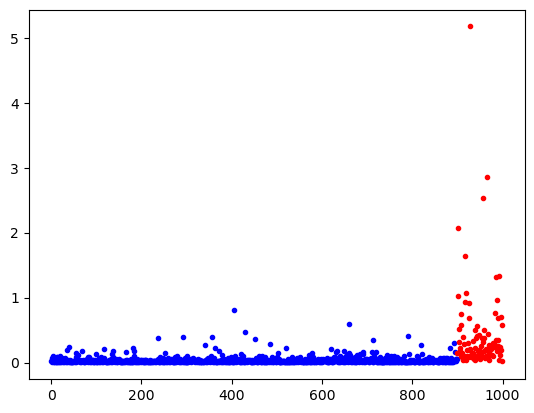

In [90]:
plt.plot(np.arange(900), scores[:-100], 'b.')
plt.plot(np.arange(100) + 900, scores[-100:], 'r.')